In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, exposure
import cv2
import math
import os
import pdb

In [2]:
def ncc(im1, im2):
    im1_mean = np.linalg.norm(im1)
    im2_mean = np.linalg.norm(im2)
    
    numerator = np.sum((im1 - im1_mean) * (im2 - im2_mean))
    denominator = np.sqrt(np.sum((im1 - im1_mean) ** 2) * np.sum((im2 - im2_mean) ** 2))
    
    return numerator / denominator if denominator != 0 else 0

In [3]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    # mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    # mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]

    mu1 = np.mean(img1)
    mu2 = np.mean(img2)
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    # sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    # sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma1_sq = np.var(img1)
    sigma2_sq = np.var(img2)
    # sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
    sigma12 = np.cov(img1.flatten(), img2.flatten())[0, 0]

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [4]:
def calculate_displacement_euclidean(im1, im2, displacement_range=30):
    """
    Calculate the displacement that best aligns im2 to im1 using an exhaustive search over a given range.
    """
    best_offset = (0, 0)
    best_score = float('inf')  # Use infinity as the initial score
    
    for x in range(-displacement_range, displacement_range + 1):
        for y in range(-displacement_range, displacement_range + 1):
            # Shift the second image
            shifted_im2 = np.roll(np.roll(im2, y, axis=0), x, axis=1)
            
            # Calculate the L2 norm (Euclidean Distance)
            score = np.sum((im1 - shifted_im2) ** 2)
            
            # Update if a better score (lower score) is found
            if score < best_score:
                best_score = score
                best_offset = (y, x)
    
    return best_offset

In [5]:
def calculate_displacement_ncc(im1, im2, displacement_range=100):
    """
    Calculate the displacement that best aligns im2 to im1 using Normalized Cross-Correlation (NCC).
    """
    best_offset = (0, 0)
    best_score = -1  # NCC ranges from -1 to 1, so we start with the lowest possible value

    for x in range(-displacement_range, displacement_range + 1):
        for y in range(-displacement_range, displacement_range + 1):
            # Shift the second image
            shifted_im2 = np.roll(np.roll(im2, y, axis=0), x, axis=1)

            ncc_score = ncc(im1, shifted_im2)
            
            if ncc_score > best_score:
                best_score = ncc_score
                best_offset = (x, y)

    return best_offset

In [6]:
def calculate_displacement_ssim(im1, im2, displacement_range=2):
    best_offset = (0, 0)
    best_score = -1  # NCC ranges from -1 to 1, so we start with the lowest possible value

    for x in range(-displacement_range, displacement_range + 1):
        for y in range(-displacement_range, displacement_range + 1):
            # Shift the second image
            shifted_im2 = np.roll(np.roll(im2, y, axis=0), x, axis=1)

            ssim_score = ssim(im1, shifted_im2)
            
            if ssim_score > best_score:
                best_score = ssim_score
                best_offset = (x, y)

    return best_offset

In [7]:
def calculate_displacement_pyramid(base_img, target_img, max_layers=5, scale_factor=0.5, search_range=100):
    base_pyramid = [base_img]
    target_pyramid = [target_img]

    # set it to 300 or 400 when trying to resolve the emir misalignment issue.
    min_size = 100
    while min(base_img.shape[:2]) > min_size:
        base_img = transform.rescale(base_img, scale_factor)
        target_img = transform.rescale(target_img, scale_factor)
        base_pyramid.append(base_img)
        target_pyramid.append(target_img)

    best_shift = (0, 0)
    num_layers = len(base_pyramid)

    for i in range(num_layers - 1, -1, -1):

        target_layer = np.roll(np.roll(target_pyramid[i], best_shift[0], axis=0), best_shift[1], axis=1)
        base_layer = base_pyramid[i]
        best_shift = calculate_displacement_ncc(base_layer, target_layer, int(search_range * (0.7 ** (num_layers - 1 - i))))
        # best_shift = calculate_displacement_ncc(base_layer, target_layer, int(search_range * (0.7 ** (num_layers - 1 - i))))
        
        # best_shift = calculate_displacement_ssim(base_layer, target_layer, 10)

        best_shift = (best_shift[0] * 2, best_shift[1] * 2)

    return best_shift

In [8]:
def align(imname, align_type="pyramid", max_layers=5):
    im = skio.imread(imname) 
    im = sk.img_as_float(im)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    crop_height = int(b.shape[0] * 0.15)
    crop_width = int(b.shape[1] * 0.15)

    b = b[crop_height:-crop_height, crop_width:-crop_width]
    g = g[crop_height:-crop_height, crop_width:-crop_width]
    r = r[crop_height:-crop_height, crop_width:-crop_width]
    
    # b = exposure.rescale_intensity(b, in_range='image', out_range=(0, 1))
    # g = exposure.rescale_intensity(g, in_range='image', out_range=(0, 1))
    # r = exposure.rescale_intensity(r, in_range='image', out_range=(0, 1))
    # skio.imshow(b)
    # skio.show()

    

    from skimage import feature
    # be = feature.canny(b)
    # ge = feature.canny(g)
    # re = feature.canny(r)
    # skio.imshow(be)
    # skio.show()
    

    if align_type == "pyramid":    
        g_offset = calculate_displacement_pyramid(b, g)
        r_offset = calculate_displacement_pyramid(b, r)
    elif align_type == "euclidean":
        g_offset = calculate_displacement_euclidean(b, g)
        r_offset = calculate_displacement_euclidean(b, r)
    elif align_type == "ncc":
        g_offset = calculate_displacement_ncc(b, g)
        r_offset = calculate_displacement_ncc(b, r)
    elif align_type == "ssim":
        g_offset = calculate_displacement_ssim(b, g)
        r_offset = calculate_displacement_ssim(b, r)


    print("r: ", r_offset)
    print("g: ", g_offset)
    ag = np.roll(np.roll(g, g_offset[0], axis=0), g_offset[1], axis=1)
    ar = np.roll(np.roll(r, r_offset[0], axis=0), r_offset[1], axis=1)
    im_out = np.dstack([ar, ag, b])
    fname = f'../output/ec_{os.path.basename(imname)}'
    skio.imsave(fname, sk.img_as_ubyte(im_out))
    print(fname, "saved!")

    # display the image
    skio.imshow(im_out)
    skio.show()
    return


In [9]:
def process_image(imname):
    if imname.lower().endswith('.tif'):
        print(f"Aligning image: {imname}")
        align(imname, "pyramid", max_layers=5)
    elif imname.lower().endswith('.jpg'):
        print(f"Aligning image: {imname}")
        align(imname, "pyramid", max_layers=3)

Aligning image: ../data/monastery.jpgAligning image: ../data/emir.tifAligning image: ../data/three_generations.tifAligning image: ../data/church.tifAligning image: ../data/melons.tif




r:  (-64, 82)
g:  (-64, 54)
../output/ec_monastery.jpg saved!


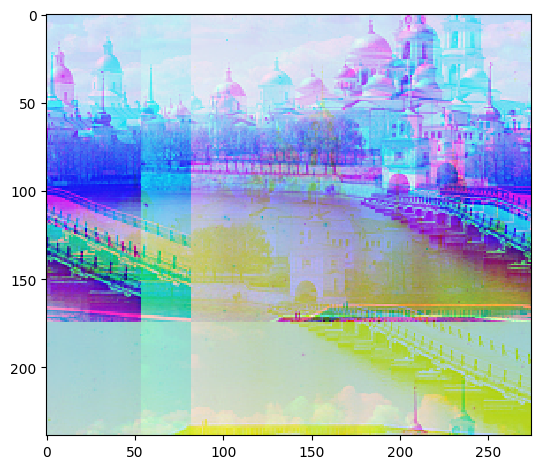

Aligning image: ../data/onion_church.tif


KeyboardInterrupt: 

r:  (-32, 32)
g:  (-32, 32)
../output/ec_church.tif saved!


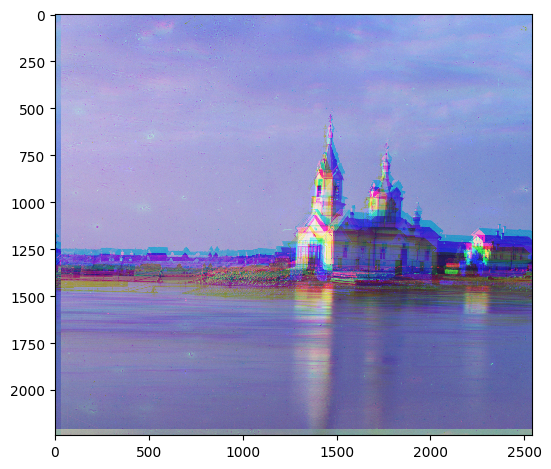

Aligning image: ../data/train.tif
r:  (-18, 32)
g:  (-32, 32)
../output/ec_emir.tif saved!
r:  (-32, 32)
g:  (-32, 32)


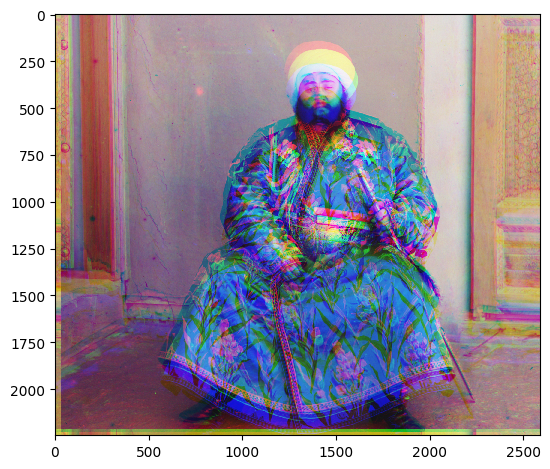

Aligning image: ../data/tobolsk.jpg
../output/ec_three_generations.tif saved!


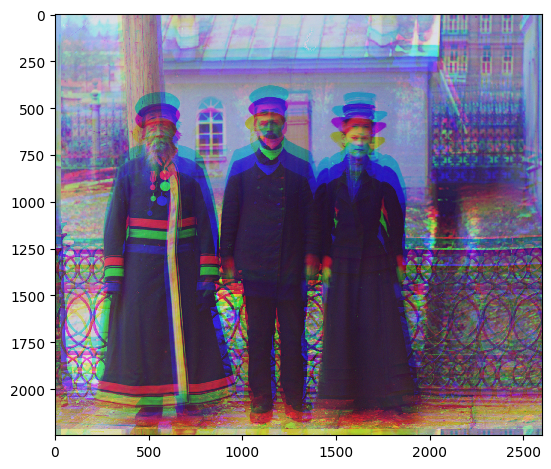

Aligning image: ../data/icon.tif
r:  (-32, 32)
g:  (-32, 32)
../output/ec_melons.tif saved!


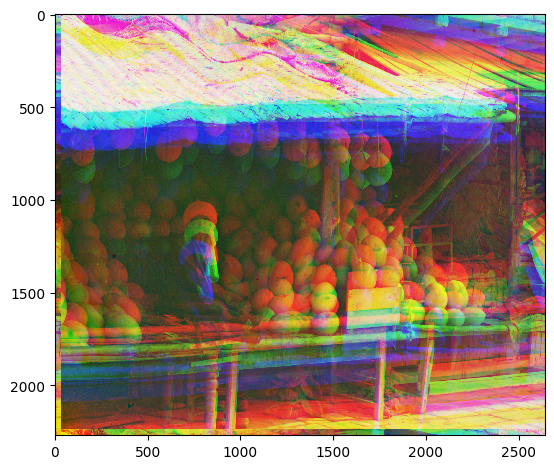

Aligning image: ../data/cathedral.jpg
r:  (-22, 32)
g:  (-32, 32)
../output/ec_onion_church.tif saved!


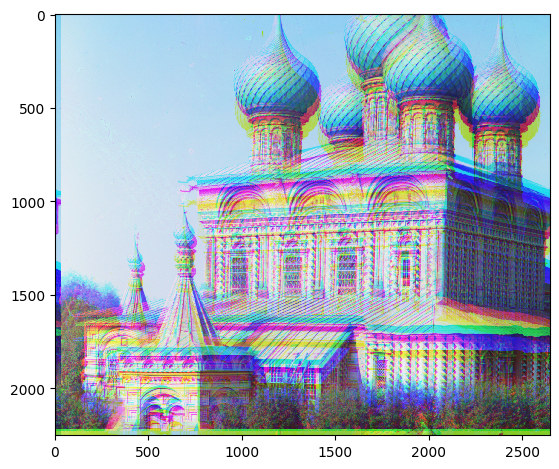

Aligning image: ../data/self_portrait.tif
r:  (-78, 88)
g:  (-70, 86)
../output/ec_tobolsk.jpg saved!


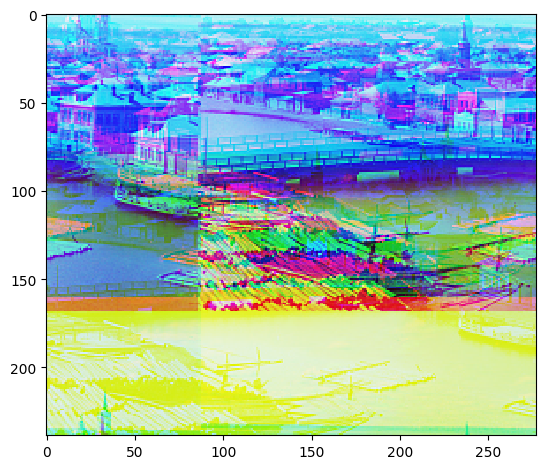

Aligning image: ../data/harvesters.tif
r:  (-78, 96)
g:  (-68, 74)
../output/ec_cathedral.jpg saved!


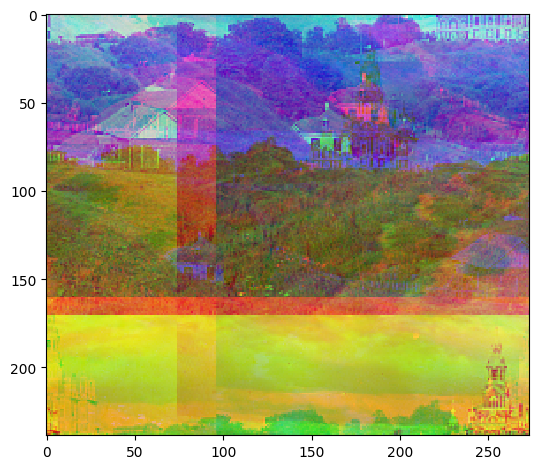

Aligning image: ../data/sculpture.tif
r:  (-32, 32)
g:  (-32, 32)
../output/ec_train.tif saved!


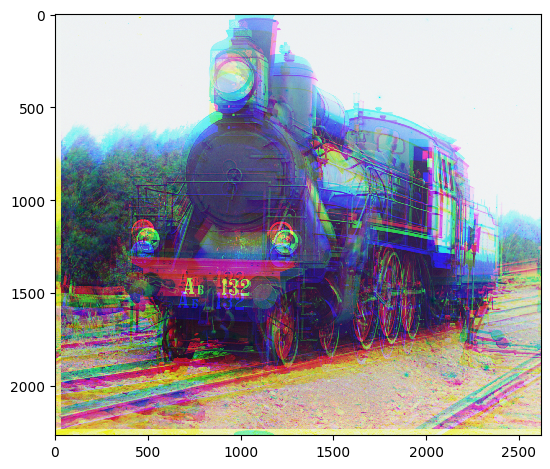

Aligning image: ../data/lady.tif
r:  (32, 32)
g:  (32, 32)
../output/ec_icon.tif saved!


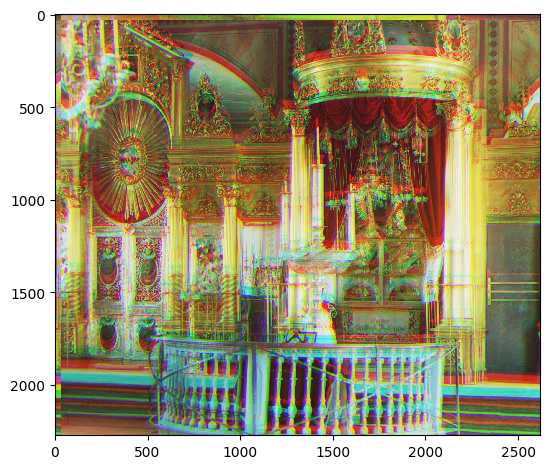

r:  (-32, 32)
g:  (-32, 32)
../output/ec_harvesters.tif saved!


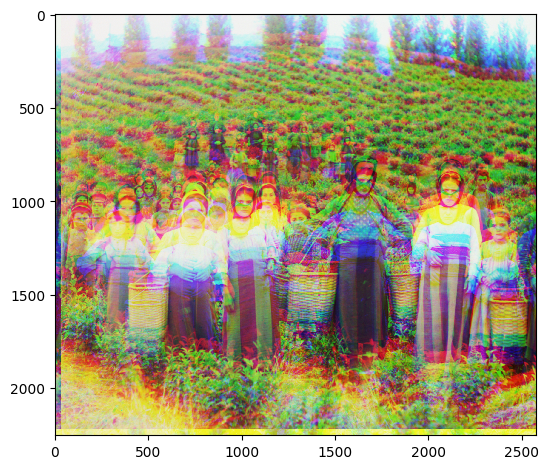

r:  (-14, 32)
g:  (-24, 32)
../output/ec_self_portrait.tif saved!


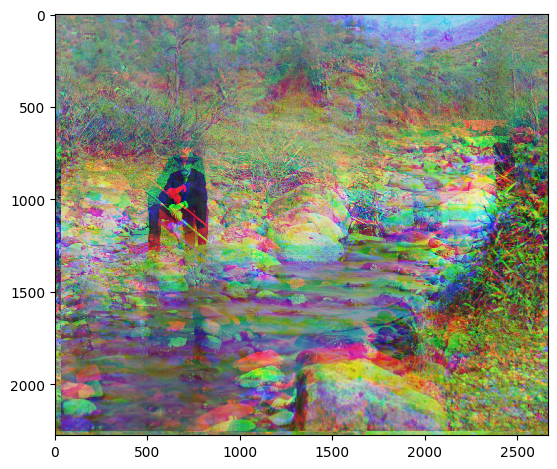

r:  (-32, 32)
g:  (14, 32)
../output/ec_sculpture.tif saved!


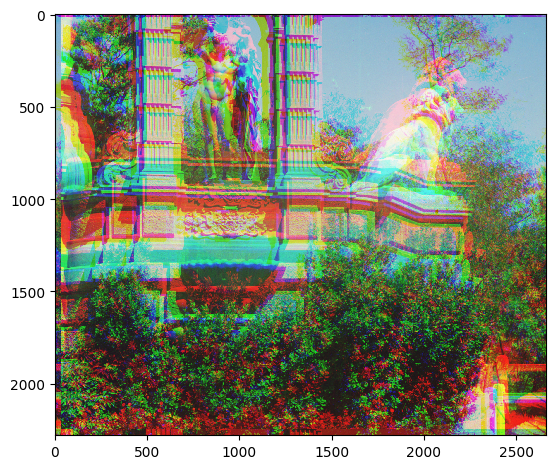

r:  (-32, 32)
g:  (-32, 32)
../output/ec_lady.tif saved!


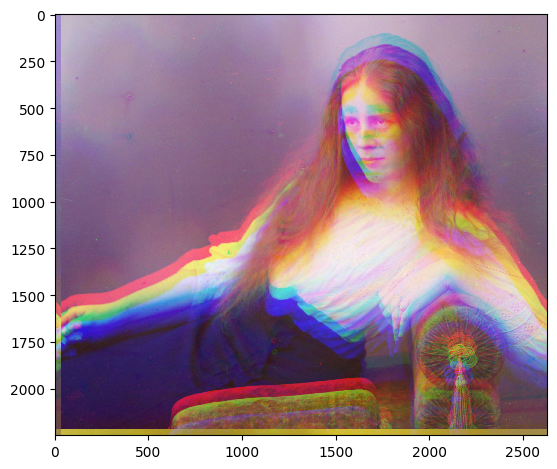

In [ ]:
import multiprocess
data_folder = '../data'

# process_image('../data/emir.tif')


pool = multiprocess.Pool(processes=5)

pool.map(process_image, [os.path.join(data_folder, f)  for f in os.listdir(data_folder)])
pool.close()
pool.join()

